# Selecting Datasets for Super Learner

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sb
from numpy.linalg import inv

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [9]:
from pmlb import fetch_data, regression_dataset_names

print(regression_dataset_names)

['1027_ESL', '1028_SWD', '1029_LEV', '1030_ERA', '1089_USCrime', '1096_FacultySalaries', '1191_BNG_pbc', '1193_BNG_lowbwt', '1196_BNG_pharynx', '1199_BNG_echoMonths', '1201_BNG_breastTumor', '1203_BNG_pwLinear', '1595_poker', '192_vineyard', '195_auto_price', '197_cpu_act', '201_pol', '207_autoPrice', '210_cloud', '215_2dplanes', '218_house_8L', '225_puma8NH', '227_cpu_small', '228_elusage', '229_pwLinear', '230_machine_cpu', '294_satellite_image', '344_mv', '4544_GeographicalOriginalofMusic', '485_analcatdata_vehicle', '503_wind', '505_tecator', '519_vinnie', '522_pm10', '523_analcatdata_neavote', '527_analcatdata_election2000', '529_pollen', '537_houses', '542_pollution', '547_no2', '556_analcatdata_apnea2', '557_analcatdata_apnea1', '560_bodyfat', '561_cpu', '562_cpu_small', '564_fried', '573_cpu_act', '574_house_16H', '579_fri_c0_250_5', '581_fri_c3_500_25', '582_fri_c1_500_25', '583_fri_c1_1000_50', '584_fri_c4_500_25', '586_fri_c3_1000_25', '588_fri_c4_1000_100', '589_fri_c2_1000

In [10]:
list_dataset = []

for dataset in regression_dataset_names:
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    if X.shape[0] >= 1000:
        list_dataset.append(dataset)

In [11]:
len(list_dataset)

46

In [90]:
X, y = fetch_data(list_dataset[0], return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [93]:
list_dataset[0]

'1028_SWD'

In [94]:
train_X.shape

(750, 10)

In [95]:
N = train_X.shape[1]
max_features = [int(x*N+1) for x in np.linspace(0.01, 2, num = 5)]
np.unique(max_features)

array([ 1,  6, 11, 16, 21])

In [96]:
N = train_X.shape[1]

max_depth = np.unique([int(x*N + 1) for x in np.linspace(0.01, 2, num = 5)])

grid = {'max_depth': max_depth}
rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs = 10)


rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, verbose=2,
                     n_jobs = 2)
rf_cv.fit(train_X, train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   17.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=10,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': array([ 1,  6, 11, 16, 21])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [85]:
rf_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=10,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [87]:
rf_cv.score(test_X, test_y)

0.556785775256839

In [88]:
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 4, 8, 16, 32, 64, 132]
def other_scores(train_X, test_X, train_y, test_y):
    
    N = train_X.shape[1]
    max_features = np.unique([int(x*N + 1) for x in np.linspace(0.01, 0.99, num = 5)])
    grid = {'max_features': max_features}
    rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs = 10)
    rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, verbose=2,
                         n_jobs = 2)
    ridge  = RidgeCV(cv=5, alphas=alphas)
    lasso = ElasticNetCV(cv=5, random_state=0, l1_ratio=1)
    dt = DecisionTreeRegressor(min_samples_leaf=10)
    
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    
    rf_cv.fit(train_X, train_y)
    lasso.fit(train_X, train_y)
    ridge.fit(train_X, train_y)
    dt.fit(train_X, train_y)
    scores = [x.score(test_X, test_y) for x in [rf_cv, ridge, lasso, dt]]
    return scores

In [99]:
dt = DecisionTreeRegressor(min_samples_leaf=10)
dt_cv = GridSearchCV(estimator = dt, param_grid = grid, cv = 5, verbose=2,
                    n_jobs = 20)
dt_cv.fit(train_X, train_y)
dt_cv.score(test_X, test_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  25 out of  25 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  25 out of  25 | elapsed:    0.5s finished


0.27999061890109034

In [97]:
dt_cv.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Conditionally interpretable super learner

In [11]:
np.random.seed(23)

def random_assignments(train_X, K=6):
    matrix
    data = {'index': range(len(train_X)), 'group':  np.random.choice(K, len(train_X)) }
    df = pd.DataFrame(data)
    return df

groups = random_assignments(train_X, K=6)
groups.head()

,index,group
0,0,5
1,1,0
2,2,3
3,3,3
4,4,2


In [303]:
np.random.random((3,2))

array([[0.44758997, 0.19069973],
       [0.20419105, 0.46605731],
       [0.82524704, 0.44576907]])

In [12]:
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 4, 8, 16, 32, 64, 132]
class BaseModel:
    def __init__(self, model_type):
        self.model_type = model_type
        self.model = self.create_model()
        if model_type not in range(1,7):
            print("model_type should be in the interval [1, 6]")
    
    def create_model(self):
        method_name = 'model_' + str(self.model_type)
        method = getattr(self, method_name, lambda: "nothing")
        return method()
    
    def model_1(self):
        return RidgeCV(cv=5, alphas=alphas)
    
    def model_2(self):
        return ElasticNetCV(cv=5, random_state=0, l1_ratio=0.5)

    def model_3(self):
        return ElasticNetCV(cv=5, random_state=0, l1_ratio=1)

    def model_4(self):
        return DecisionTreeRegressor(max_depth=1)
    
    def model_5(self):
        return DecisionTreeRegressor(max_depth=3)
    
    def model_6(self):
        return DecisionTreeRegressor(max_depth=5)

In [13]:
r = BaseModel(6)
type(r.model)

sklearn.tree.tree.DecisionTreeRegressor

In [14]:
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 4, 8, 16, 32, 64, 132]
def fit_K_models(train_X, train_y, groups, model_types, K=6):
    models = []
    for k in range(K):
        ind = groups[groups["group"] == k].index.values
        X = train_X[ind]
        y = train_y[ind]
        if len(ind) > 10:
            base_model = BaseModel(model_types[k])
            base_model.model.fit(X, y)
            models.append(base_model)
    return models

In [15]:
def compute_K_model_loss(train_X, train_y, models):
    L = []
    for i in range(len(models)):
        loss = (models[i].model.predict(train_X) - train_y)**2
        L.append(loss)
    L = np.array(L)
    return L

In [16]:
def compute_weights(L, K):
    JI_K = inv(np.ones((K, K)) - np.identity(K))
    W = []
    for i in range(L.shape[1]):
        w_i = np.matmul(JI_K, L[:,i])
        W.append(w_i)
    return np.array(W)

In [17]:
def create_extended_dataset(train_X, train_y, models):
    K = len(models)
    N = train_X.shape[0]
    L = compute_K_model_loss(train_X, train_y, models)
    W = compute_weights(L, K)
    X_ext = []
    y_ext = []
    w_ext = []
    for i in range(K):
        X_ext.append(train_X.copy())
        y_ext.append(i*np.ones(N))
        w_ext.append(W[:, i])
    X_ext = np.concatenate(X_ext, axis=0)
    y_ext = np.concatenate(y_ext, axis=0)
    w_ext = np.concatenate(w_ext, axis=0)
    return X_ext, y_ext, w_ext

## Neural Network oracle

In [301]:
def create_oracle_model(D_in, K, N):
    """ Returns an oracle model
    
    The size of the hidden layer is a function of the
    amount of training data
    """
    H = int(2*np.log(N)**2)
    model = nn.Sequential(
        nn.Linear(D_in, H),
        nn.BatchNorm1d(H),
        nn.ReLU(),
        torch.nn.Linear(H, K))
    return model
#nn.Dropout(p=0.2),

In [19]:
def softmax_loss(beta, f_hat, y, w):
    y_hat = np.exp(beta*f_hat)
    den = (np.exp(beta*f_hat)).sum(axis=1)
    y_hat = np.array([y_hat[i]/den[i] for i in range(len(den))])
    loss = w*((y * (1- y_hat)).sum(axis=1))
    return loss.mean()

In [20]:
beta = torch.tensor(1).float()
f_hat = torch.tensor([[1, 2, 4], [1, 2, 3]]).float()
y = torch.tensor([[0, 0, 1], [0, 0, 1]]).float()
w = torch.tensor([1, 1]).float()
#sofmax_loss(beta, f_hat, y, w)

In [21]:
f_hat = beta*f_hat
y_hat = F.softmax(f_hat, dim=1)
loss = (y*(1-y_hat)).sum(dim=1)
(w*loss).mean()

tensor(0.2455)

In [89]:
def bounded_loss(beta, y_hat, y , w):
    #y_hat = beta*y_hat
    y_hat = F.softmax(y_hat, dim=1)
    loss = (y*(1-y_hat)).sum(dim=1)
    return (w*loss).mean()

In [297]:
def train_oracle_model(model, train_dl, K, learning_rate = 0.01, epochs=100):
    beta = 1
    wd=0 #0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    KK = epochs//10 + 1
    model.train()
    for t in range(epochs):
        total_loss = 0
        total = 0
        for x, y, w in train_dl:
            x = x.cuda().float()
            y = y.cuda().long()
            w = w.cuda().float()
            y_onehot = torch.FloatTensor(y.shape[0], K).cuda()
            y_onehot.zero_()
            y_onehot = y_onehot.scatter_(1, y.unsqueeze(1), 1)
            y_hat = model(x)
            loss = bounded_loss(beta, y_hat, y_onehot , w)
       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*y.size(0)
            total += y.size(0)
        #if t % KK == 0: print(total_loss/total)
        print(total_loss/total)

In [24]:
def reasign_points(train_X, model):
    x = torch.tensor(train_X).float()
    y_hat = model(x.cuda())
    _, pred = torch.max(y_hat, 1)
    data = {'index': range(len(train_X)), 'group': pred.cpu().numpy()  }
    return pd.DataFrame(data) 

In [25]:
def relabel_groups(groups, models):
    unique_models = groups.group.unique()
    old2new = {x:i for i,x in enumerate(unique_models)}
    ratios = []
    model_types = [models[i].model_type for i in unique_models]
    groups.group = np.array([old2new[x] for x in groups.group.values])
    return groups, model_types

In [26]:
from sklearn.metrics import r2_score

In [71]:
def compute_loss(X, y, oracle, models):
    oracle.eval()
    x = torch.tensor(X).float()
    y = torch.tensor(y).float()
    y_hat = oracle(x.cuda())
    _, ass = torch.max(y_hat, 1)
    preds = []
    ys = []
    for i in range(len(models)):
        xx = x[ass==i]
        yy = y[ass==i]
        if len(xx) > 0:
            pred = models[i].model.predict(xx.cpu().numpy())
            preds.append(pred)
            ys.append(yy.cpu().numpy())
    preds = np.hstack(preds)
    ys = np.hstack(ys)
    r2 = r2_score(ys, preds)
    res = (ys - preds)**2
    return res.mean(), r2

In [45]:
def compute_single_loss(X, y, model):
    pred = model.model.predict(X)
    r2 = r2_score(y, pred)
    res = (y - pred)**2
    return res.mean(), r2

## Loop

In [28]:
def random_assignments(train_X, K=6):
    data = {'index': range(len(train_X)), 'group':  np.random.choice(K, len(train_X)) }
    df = pd.DataFrame(data)
    return df

In [29]:
class OracleDataset(Dataset):
    def __init__(self, X, y, w):
        self.X = X
        self.y = y
        self.w = w
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.w[idx]

In [268]:
def get_optimizer(model, lr = 0.01, wd = 0.0001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [269]:
PATH = Path("/data2/yinterian/tmp/")
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, K, lr_low=1e-5, lr_high=1, epochs=10):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y, w in train_dl:
            optimizer = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().long()
            w = w.cuda().float()
            y_onehot = torch.FloatTensor(y.shape[0], K).cuda()
            y_onehot.zero_()
            y_onehot = y_onehot.scatter_(1, y.unsqueeze(1), 1)
            y_hat = model(x)
            loss = bounded_loss(beta, y_hat, y_onehot , w)
       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ind +=1
            losses.append(loss.item())
            
    load_model(model, str(p))
    return lrs, losses

In [186]:
# difficult problems 5, 7, 22
dataset = list_dataset[9]
print(dataset)
X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
train_X, test_X, train_y, test_y = train_test_split(X, y)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
print(train_X.shape)

1595_poker
(768757, 10)


In [270]:
def oracle_LR_range_finder(train_X, train_y, K=6):
    groups = random_assignments(train_X, K)
    models = fit_K_models(train_X, train_y, groups, model_types, K)
    K = len(models)
    print("models")
    X_ext, y_ext, w_ext = create_extended_dataset(train_X, train_y, models)
    train_ds = OracleDataset(X_ext, y_ext, w_ext)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = create_oracle_model(train_X.shape[1], K, N).cuda()
    lrs, losses = LR_range_finder(model, train_dl, K, lr_low=1e-5, lr_high=0.5)
    return lrs, losses

In [271]:
Losses = {}
Lrs = {}
for dataset in list_dataset[0]:
    dataset = "1595_poker"
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    Lrs[dataset], Losses[dataset] = oracle_LR_range_finder(train_X, train_y, 6)

/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models
models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models
models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


/home/yinterian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


models


In [242]:
lr_map = {"1028_SWD": 0.15, "1029_LEV" :0.15, "1030_ERA": 0.15, "1191_BNG_pbc": 0.02,
         "1193_BNG_lowbwt": 0.1, "1196_BNG_pharynx": 0.015, "1199_BNG_echoMonths": 0.3,
         "1203_BNG_pwLinear": 0.05, "1595_poker": 0.01, "1201_BNG_breastTumor": 0.05, "197_cpu_act": 0.2,
         "201_pol": 0.15, "215_2dplanes": 0.1, "218_house_8L": 0.05, "225_puma8NH": 0.15,
         "227_cpu_small":0.15, "294_satellite_image": 0.15, "344_mv": 0.1,
          "4544_GeographicalOriginalofMusic": 0.15, "503_wind": 0.1, "529_pollen": 0.1,
         "537_houses": 0.15, "562_cpu_small": 0.15, "564_fried": 0.1, "573_cpu_act": 0.15,
         "574_house_16H": 0.15, "583_fri_c1_1000_50": 0.15, "586_fri_c3_1000_25": 0.15 }

606_fri_c2_1000_10


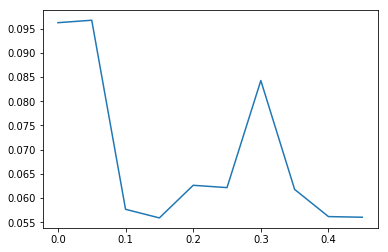

In [282]:
dataset = list(Lrs.keys())[10]
lrs = Lrs[dataset]
losses = Losses[dataset]
plt.plot(lrs[:100], losses[:100])
print(dataset)
plt.show()

In [286]:
# difficult problems 5, 7, 22
dataset = list_dataset[9]
print(dataset)
X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
train_X, test_X, train_y, test_y = train_test_split(X, y)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
print(train_X.shape)

1595_poker
(768757, 10)


In [302]:
K = 6
groups = random_assignments(train_X, K)
f = open('out2.log', 'w+')
batch_size = 100000
# number of iterations depends on the number of training points
N = train_X.shape[0]
N_iter = int(100/np.log(N))
print("Number of training points %d, number iterations %d" % (N, N_iter))

best_train_r2 = None
best_K = None
best_test_r2 = None
model_types = range(1,7)
learning_rate = lr_map.get(dataset, 0.15)
learning_rate = 0.01
for i in range(5):
    print("iter", i)
    models = fit_K_models(train_X, train_y, groups, model_types, K)
    K = len(models)
    print("K is ", K)
    if K == 1:
        models[0].model.fit(train_X, train_y)
        train_loss, train_r2 = compute_single_loss(train_X, train_y, models[0])
        test_loss, test_r2 = compute_single_loss(test_X, test_y, models[0])
        if train_r2 >= best_train_r2:
            best_train_r2 = train_r2
            best_test_r2 = test_r2
            best_K = K
        break
    
    X_ext, y_ext, w_ext = create_extended_dataset(train_X, train_y, models)
    train_ds = OracleDataset(X_ext, y_ext, w_ext)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = create_oracle_model(train_X.shape[1], K, N).cuda()
    train_oracle_model(model, train_dl, K, learning_rate, N_iter)
    groups = reasign_points(train_X, model)
    if len(groups.group.unique()) < K:
        K = len(groups.group.unique()) 
        groups, model_types = relabel_groups(groups, models)
    train_loss, train_r2 = compute_loss(train_X, train_y, model, models)
    if best_train_r2 == None:
        best_train_r2 = train_r2
        
    test_loss, test_r2 = compute_loss(test_X, test_y, model, models)
    if train_r2 >= best_train_r2:
        best_train_r2 = train_r2
        best_test_r2 = test_r2
        best_K = K
    print("loss", train_loss, test_loss)
    print("R^2", train_r2, test_r2)
    print("best test_r2", best_test_r2)
    
scores = other_scores(train_X, test_X, train_y, test_y)
model_str = ["RF", "Ridge", "Lasso", "Cart"]
score_str = ["%s %.4f" % (s, score) for s,score in zip(model_str, scores)]
score_str = " ".join(score_str)
results = "dataset %s K %d ISL %.4f %s"  %(dataset, best_K, best_test_r2, score_str)
print(results)
f.write(results)
f.write('\n')
f.flush()

Number of training points 768757, number iterations 7
iter 0
K is  6
0.0939282810948239
0.09370957819470474
0.09370957245216126
0.09370957023497589
0.09370956913057164
0.09370956521041793
0.09370956592651034
loss 0.5622573214878374 0.5611105723670703
R^2 0.06169420169799844 0.060192458771465396
best test_r2 0.060192458771465396
iter 1
K is  1
dataset 1595_poker K 1 ISL 0.0652 RF 0.3684 Ridge 0.0000 Lasso 0.0000 Cart 0.2692


In [298]:
model_types

[6]